## Neural Cellular Automata on PyTorch: The basics

This notebook is a "pytorch translation" of [this youtube video](https://www.youtube.com/watch?v=8EN_8p9Toyc) by Alexander Mordvintsev.

#### Important links:
* [Differentiable Self-organizing Systems thread on Distill](https://distill.pub/2020/selforg/)
* [Original Neural CA paper](https://distill.pub/2020/growing-ca/)
* [Another paper: Cellular automata as convolutional neural networks](https://arxiv.org/abs/1809.02942)

This implementation might not be 100% accurate. If you want to suggest any changes, feel free to make a PR :)

_note_: This is a walkthrough notebook. If you want to copy and paste stuff, here's a [link to another notebook]() that I wrote just for your (and my) convenience. 

In [1]:
import cv2 
import torch
import numpy as np
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from IPython.display import Image, HTML, clear_output

In [ ]:
# !wget -O flower.png https://raw.githubusercontent.com/googlefonts/noto-emoji/master/png/128/emoji_u1f33a.png
!wget -O lizard.png https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/160/google/274/lizard_1f98e.png
# ! wget -O duck.png https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/160/google/274/duck_1f986.png

## A brief intro

A cellular automaton is a collection of cells on a grid of specified shape that evolves through a number of discrete time steps according to a set of rules based on the states of neighboring cells. The rules are then applied iteratively for as many time steps as desired.

Now let's ask the following question:

**What if we could use a neural network to map a certain set of rules  that would help us generate a very specific arrangement of "cells" ?**

This is exactly what our objective is in this notebook.



## Let us start out by loading a target image

Do note that our image is a PNG file, this means that the image contains 4 channels: `[R,G,B,A]`

The image is intentionally small for fast and stable results. 

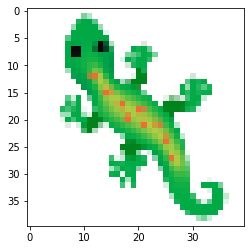

(40, 40, 4)


In [3]:
width = 40
height = 40
filename = 'lizard.png'
device = 'cuda'
im = (cv2.cvtColor(cv2.resize(cv2.imread(filename, cv2.IMREAD_UNCHANGED), (width,height)), cv2.COLOR_BGRA2RGBA)/255.0).astype(np.float32)
plt.imshow(im)
plt.show()
print(im.shape)

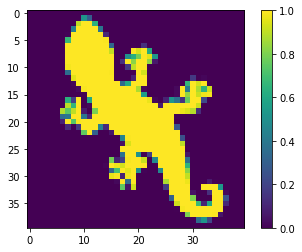

In [4]:
plt.imshow(im[:,:,3])  ## last channel 
plt.colorbar()

## Preparing a seed 

I'll break it down line by line:

* The seed will contain `16` channels, of which the first 4 would be the `[R,G,B,A]` channels, and the rest would be used by the NN to store some underlying information through the cellular automata steps.

* The seed would be a 4D array of dimensions `[1, width, height, 16]` with  

* We set the "center" value of the last 13 channels to 1

The white background is because the "alpha" channel value for all those pixel positions is zero. The black dot is there because the center value of the alpha channel is 1 (thus exposing the zeros from the `[R,G,B]` channels)

In [5]:
num_channels = 16
seed = np.zeros([1, width, height, num_channels], np.float32)
seed[:,width//2, height//2, 3:] = 1.0

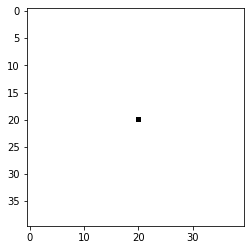

In [6]:
plt.imshow(seed[0,:,:,:4])
plt.show()

## Initializing the model

I'll break it down into 4 sections:
* Layers
* Special initialization conditions 
* Forward function
* Gradient normalization

### Layers

There are 2 layers:

**Layer 1**:  Simple conv layer, it's output size (per channel) is the same as the input size `(40,40)`. This is because the combination of `kernel_size` and `padding` is such that it's equivalent to "same" padding. The condition for same padding is:

```
padding = (kernel_size -1)/2 
## odd kernel size
```

**Layer 2**: Here we map the input back to the input shape: `[1, 16 , 40, 40]`. Note that the kernel size is 1 for "per cell" updates

### Special initialization conditions 

1. All the biases are set to zero
2. Weights of last layer are set to zero

This is because we want the initial condition of the model to be equivalent to an "identity function" that does nothing to the input image.
    
        
### Forward function:

The forward function might remind you of residual nets. Instead of directly returning an output, it adds the result into the input tensor and returns the updated tensor. 

### Gradient normalization

This is done in order to make sure our gradient stay on a constant value, thus leading to more stable training.

In [7]:
class ca_model(nn.Module):
    def __init__(self, checkpoint = None):
        super(ca_model, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size = 3,padding =1,  bias = True),  
            nn.ReLU(),
            nn.Conv2d(128, 16, kernel_size =  1, bias = True),
        )


        '''
        initial condition for "do nothing" behaviour:
            * all biases should be zero
            * the weights of the last layer should be zero
        '''
        self.model[0].bias.data.fill_(0)
        self.model[2].weight.data.fill_(0)
        self.model[2].bias.data.fill_(0)

        
    def forward(self, x):
        
        out = x + self.model(x)  ## reminds me of residual nets 
        return out

## Verifying the model's "do nothing behaviour"

We pass the input image through the model 100 times, and verify that it's still the same as the original input image

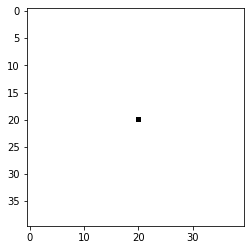

(0.00015625, 0.0, 1.0)

In [9]:
x = torch.tensor(seed).permute(0,-1,1,2).to(device)

for i in range(100):
    x = model(x)

out = x[0].permute(-1, -2,0).cpu().detach().numpy()[:,:,:4]
plt.imshow(out)
plt.show()
out.mean(), out.min(), out.max()


### Training boilerplate

* `train_step`: makes n forward passes through the model and calculates the loss w.r.t the target image
* `to_rgb`: converts 4 channel images to RGB

Given a starting point (`seed`), the model will learn to reproduce the target image (`target`) within n iterations `iters`

In [10]:
def train_step(model, target, loss_func, iters, seed):
    x = seed 
    for i in range(iters):
        x =  model(x)
    loss = loss_func(x[:,:4, :,:], target)
    return loss, x


def to_rgb(img):
    rgb, a = img[:,:,:3], img[:,:,3:4]
    return 1.0-a+rgb

## Preparing for training 

Try to run this on an Nvidia GPU for faster results

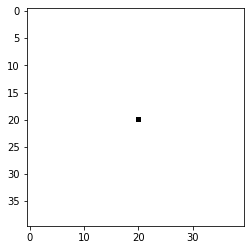

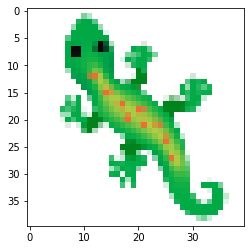

In [11]:
model = ca_model().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)


seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
target = torch.tensor(im.transpose(-1,0,1)).unsqueeze(0).to(device)

plt.imshow(seed_tensor[:,:4,:,:].cpu().permute(0,2,3,1).squeeze(0))
plt.show()

plt.imshow(target.cpu().permute(0,2,3,1).squeeze(0))
plt.show()

losses = []
samples = []



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


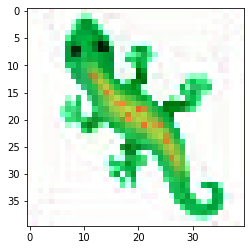

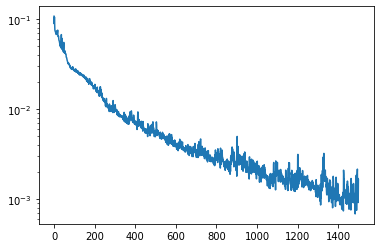

1499



In [12]:
epochs  = 1500
for i in tqdm(range(epochs)):


    loss, out = train_step(
        model = model, 
        target = target, 
        loss_func = F.mse_loss, 
        iters = 50,
        seed = seed_tensor
        )
    loss.backward()

    for p in model.parameters():
        '''
        gradient normalization for constant step size and to avoid spikes 
        '''
        p.grad.data = p.grad.data/(p.grad.data.norm()+1e-9)


    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())


    if i % 100 ==0 or i  == epochs-1:
        # samples.append(x[0].permute(-1, -2,0).cpu().detach().numpy()[:,:,:4])
        clear_output()
        samples.append(to_rgb(out[0].permute(-2, -1,0).cpu().detach().numpy()))
        plt.imshow(to_rgb(out[0].permute(-2, -1,0).cpu().detach().numpy()))
        plt.show()

        plt.plot(losses)
        # plt.plot(grads)
        plt.yscale('log')
        plt.show()
        print(i)





## The model works pretty well, but there are some issues




### The model does not really work like actual cellular automata 

In real cellular automata, only those cells are allowed to take values which have at least one "alive" cell adjacent to it. 

But here we see that the model tends to fill up the background with  random green patches first and then it slowly converges into the target. 

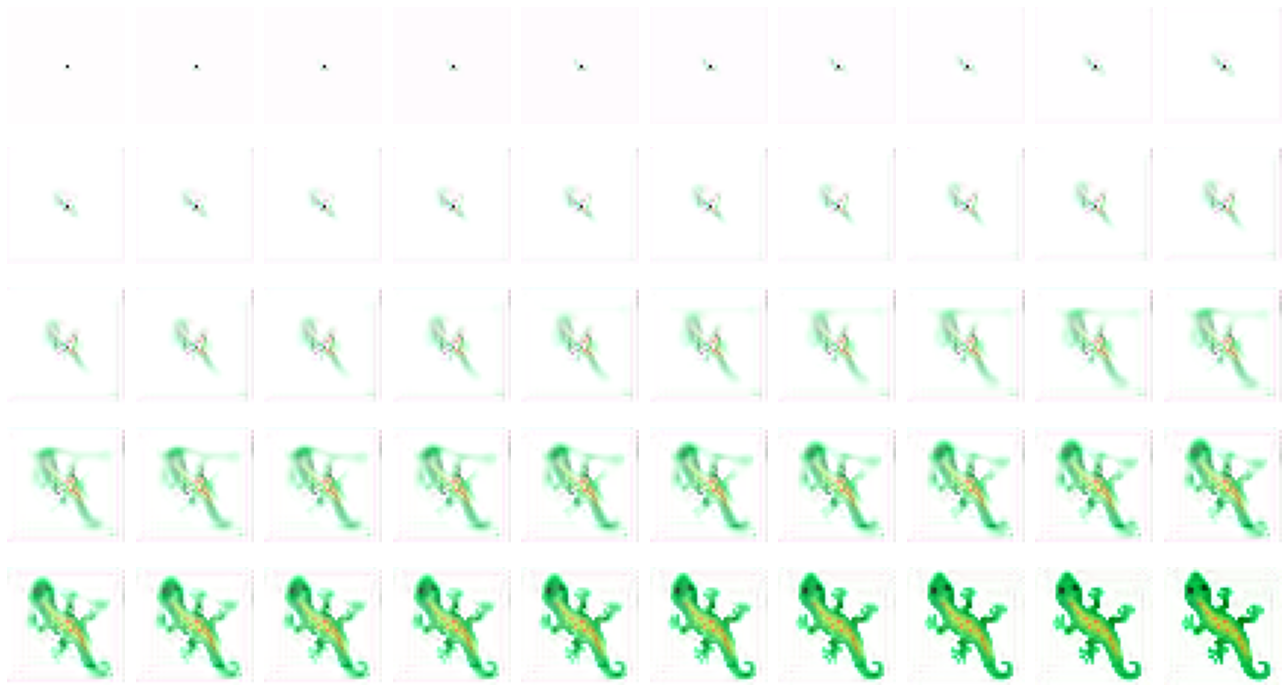

In [16]:
x = torch.tensor(seed).permute(0,-1,1,2).to(device)

outs = []
with torch.no_grad():

    for i in range(50):
        x = model(x)
        out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
        outs.append(out)

fig, ax = plt.subplots(nrows=5, ncols=10, figsize = (18,10))

for i in range(len(outs)):
    ax.flat[i].imshow(outs[i])
    ax.flat[i].axis("off")
    
fig.tight_layout()

## Overfitting w.r.t corners 

When we run inference on a larger image, the model tends to create bad outputs. The reason is that the model overfitted w.r.t the position of the corners in the image. 

In [13]:
num_channels = 16
new_width, new_height = 50,50
new_seed = np.zeros([1, new_width, new_height, num_channels], np.float32)
new_seed[:,new_width//2, new_height//2, 3:] = 1.0

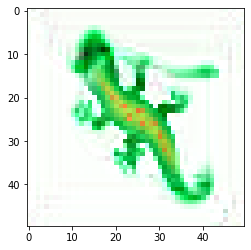

In [14]:
x = torch.tensor(new_seed).permute(0,-1,1,2).to(device)

with torch.no_grad():

    for i in range(50):
        x = model(x)

out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
plt.imshow(out)

## The issues seen above can be fixed with the following:

1. **dilution**: Multiplying the update value from the model with a mask of 1's and 0's makes sure that only a fraction of the model's outputs actually make it to the final update. This might slow down the training, but it does make the model more immune to the random nature of the CA

4. **alive masking**: only those cells should be able to hold non zero values which have at least one alive cell adjacent to it. In this system, an alive cell is any cell with an alpha channel value > 0.1

5. **pooled sampling**: Until now, the model only learned to produce the target from a seed. But now we'll train it to reach the target from random stages of growth. This will be done by saving the model's outputs into a large pool, and using them as seeds while training. 

    In order to make sure that the model does not "forget" how to produce the target from scratch, we include at least one original seed in the batches. 


In [ ]:
class ca_model(nn.Module):
    def __init__(self, checkpoint = None, seq_layers = None, device = 'cuda'):
        '''
        Kind of a modular class for a CA model
        args:
            checkpoint = 'path/to/model.pt'
            seq_layers = nn.Sequential(your, pytorch, layers)
            device = 'cuda' or 'cpu'
        '''
        super(ca_model, self).__init__()

        if seq_layers is not None:
            self.model = seq_layers
        else:
            self.model = nn.Sequential(
                nn.Conv2d(16, 256, kernel_size = 3,padding =1,  bias = True), 
                nn.ReLU(),
                nn.Conv2d(256, 16, kernel_size =  1, bias = True),
            )
            
        '''
        initial condition for "do nothing" behaviour:
            * all biases should be zero
            * the weights of the last layer should be zero
        '''
        for l in range(len(self.model)):
            if isinstance(self.model[l], nn.Conv2d):
                self.model[l].bias.data.fill_(0)
                if l == len(self.model) -1:
                    self.model[l].weight.data.fill_(0)

        if checkpoint is not None:
            self.load_state_dict(torch.load(checkpoint))

        self.to(device= device)
        
    def normalize_grads(self):
        '''
        gradient normalization for constant step size and to avoid spikes 
        '''
        for p in self.parameters():
            p.grad.data = p.grad.data/(p.grad.data.norm()+1e-8)    
            
            
    def get_alive_mask(self, x):
        '''
        looks for cells that have values over 0.1, 
        and allows only their adjacent cells to participate in growth
        '''
        alpha = x[:,3:4,:,:]
        pooled = (F.max_pool2d(alpha, 3,1, padding =1 ) > 0.1).float()
        return pooled
    
    def train_step(self, seed, target, target_loss_func, iters):
        '''
        a single training step for the model,
        feel free to play around with different loss functions like L1 loss 

        the loss is calculated for only the first 4 channels of the output
        '''
        x = seed 
        for i in range(iters):
            x =  self.forward(x)

        target_loss  =  target_loss_func(x[:,:4, :,:], target)  
        loss = target_loss 
            
        return loss, x

    def forward(self, x):
        '''
        nice little forward function for the model
        1. fetches an alive mask 
        2. generates another random mask of 0's and 1's 
        3. updates the input 
        4. applies alive mask 
        '''
        
        alive_mask = self.get_alive_mask(x)
        mask = torch.clamp(torch.round(torch.rand_like(x[:,:1,:,:])) , 0,1)        
        out = x + self.model(x)*mask  
        out *= alive_mask
        
        return out


## Time to train our new and improved model

In [ ]:
model = ca_model(device = 'cuda')
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1000, gamma=0.5) 

seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to('cpu')
target = torch.tensor(im.transpose(-1,0,1)).unsqueeze(0).to('cpu')
seed_pool = torch.repeat_interleave(seed_tensor, repeats = 1024, dim = 0)
losses = []


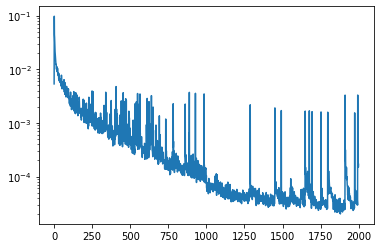

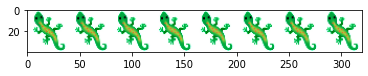

1999 0.00016921429778449237


In [ ]:

epochs = 2000
sample_size = 8
target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')

for i in range(epochs):

    scheduler.step()
    batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
    
    seed_batch = seed_pool[batch_idx].to('cuda')
    
    seed_batch[:1] = seed_tensor.to('cuda')
    
    loss, out = model.train_step(
        target = target_batch, 
        target_loss_func = F.mse_loss, 
        iters = 100,
        seed = seed_batch,
        )
    
    seed_pool[batch_idx] = out.detach().to('cpu')
    ## calculate gradients
    loss.backward()

    ## normalize them
    model.normalize_grads()
    
    ## update weights and biases 
    optimizer.step()
    
    ## prevent accumulation of gradients
    optimizer.zero_grad()

    losses.append(loss.item())

    if i % 20==0 or i  == epochs-1:
        clear_output(True)

        plt.plot(losses)
        plt.yscale('log')
        plt.show()

        stack = []
        for z in range(sample_size):
            stack.append(to_rgb(out[z].permute(-2, -1,0).cpu().detach().numpy()))
        plt.imshow(np.clip(cv2.hconcat(stack), 0,1))
        plt.show()
        
        print(i, loss.item(), flush = True)


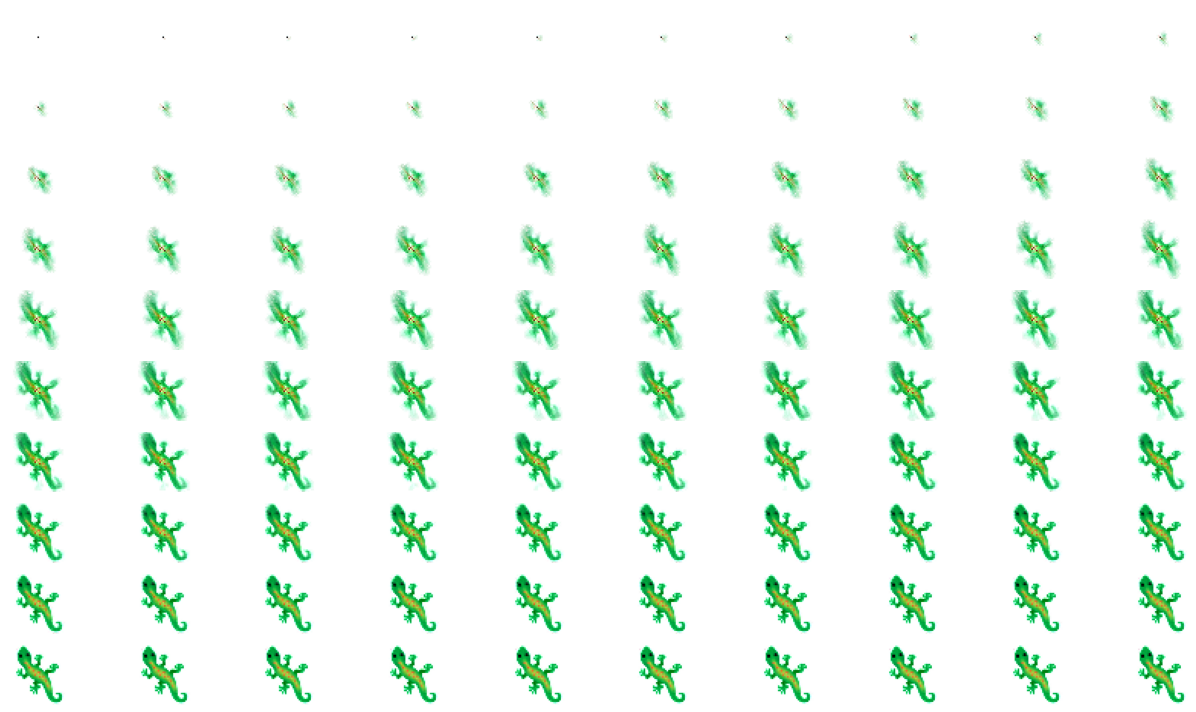

In [ ]:
x = torch.tensor(seed).permute(0,-1,1,2).to(device)

outs = []
with torch.no_grad():

    for i in range(100):
        x = model(x)
        out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
        outs.append(out)

fig, ax = plt.subplots(nrows=10, ncols=10, figsize = (18,10))

for i in range(len(outs)):
    ax.flat[i].imshow(outs[i])
    ax.flat[i].axis("off")
    
fig.tight_layout()

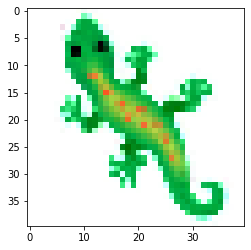

In [ ]:
plt.imshow(outs[-1])

In [ ]:
# build gif
import imageio
with imageio.get_writer('lizard.gif', mode='I', duration = 0.005) as writer:
    for out in outs:
        writer.append_data((out*255).astype(np.uint8))

writer.close()

In [ ]:
torch.save(model.state_dict(), 'nca_lizard.pt')